<a href="https://colab.research.google.com/github/drFahlan/tumor-cell-detection-using-small-and-large-FoV/blob/main/notebooks/EDA_and_data_pre_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#setup

##Gdrive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**ocelot dataset link**: https://lunit-io.github.io/research/ocelot_dataset/

**KEY TAKEAWAYS**



1. total of 304 WSI from TCGA database
2. 6:2:2 stratified data splitting
3. data splitting per WSI
4. small FoV 1024x1024 pixels
5. large FoV 4096x4096 pixels (check later)

- annotation strategy refer to the link above



**METADATA**

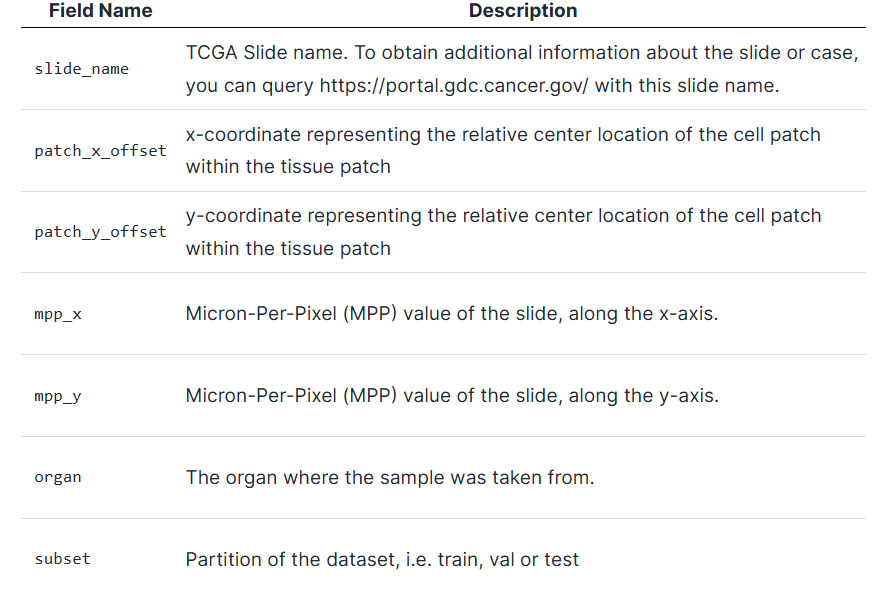

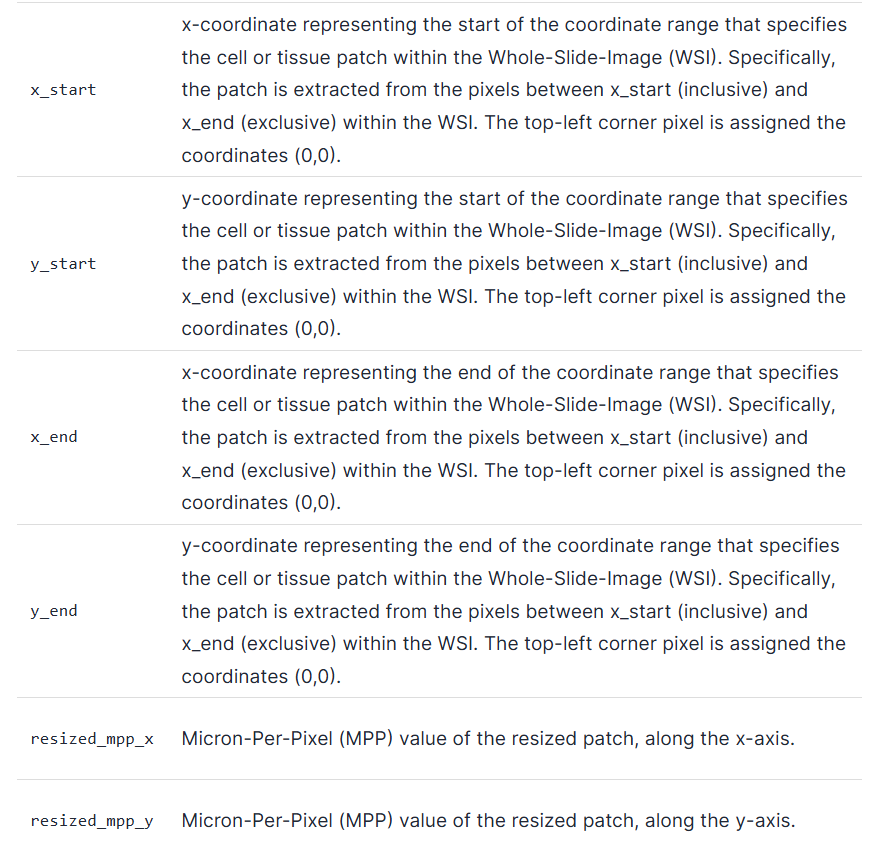

**STATISTICS**

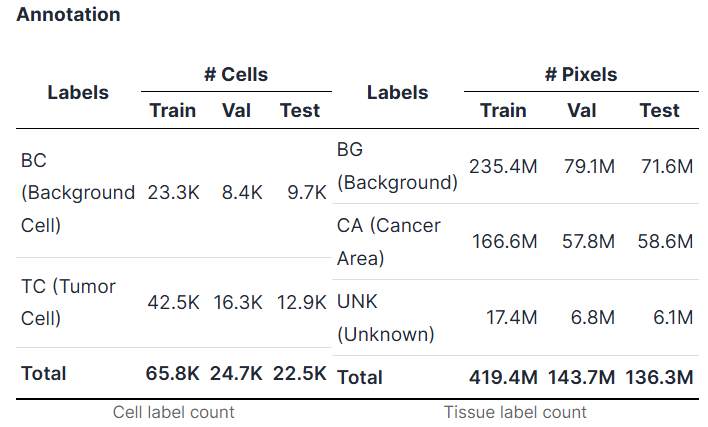

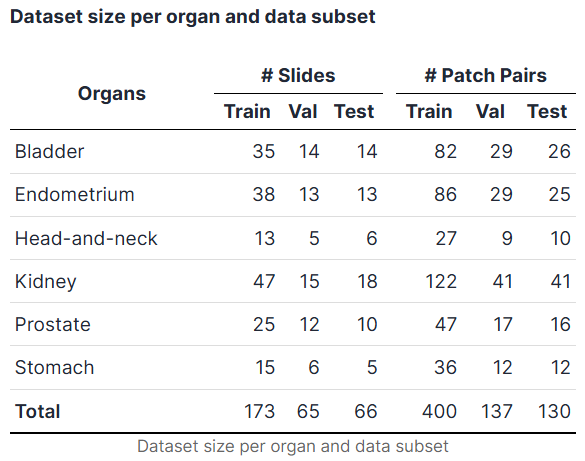

#first EDA-tissue


## data loading



1. make sure successful data loading
2. make sure successful data visualization



Found 137 images.


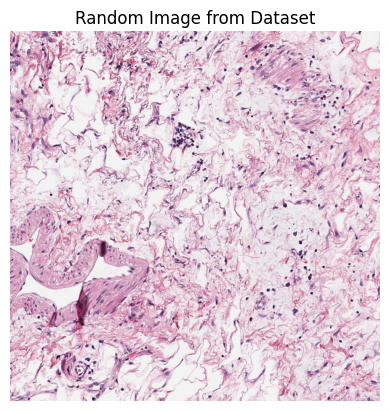

Random image '499.jpg' loaded and displayed successfully.
Metadata loaded successfully.
Found 137 annotations.


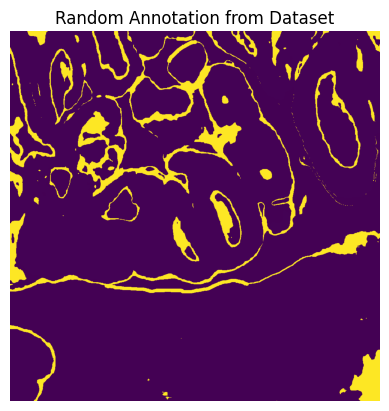

Random annotation '469.png' loaded and displayed successfully.


In [30]:
import os
import json
import pandas as pd
import random
import matplotlib.pyplot as plt
from PIL import Image

# Define the paths to your dataset, metadata, and annotations
data_directory = '/content/drive/MyDrive/research/ocelot/dataset/ocelot2023_v1.0.1/images/val/tissue'
metadata_path = '/content/drive/MyDrive/research/ocelot/dataset/ocelot2023_v1.0.1/metadata.json'
annotations_directory = '/content/drive/MyDrive/research/ocelot/dataset/ocelot2023_v1.0.1/annotations/val/tissue'

# List all image files in the directory
image_files = [f for f in os.listdir(data_directory) if f.endswith('.png') or f.endswith('.jpg')]

# Check if there are any images in the directory
if not image_files:
    print("No images found in the directory.")
else:
    print(f"Found {len(image_files)} images.")

    # Randomly select an image
    random_image_file = random.choice(image_files)
    random_image_path = os.path.join(data_directory, random_image_file)

    try:
        random_image = Image.open(random_image_path)
        plt.imshow(random_image)
        plt.title("Random Image from Dataset")
        plt.axis('off')
        plt.show()
        print(f"Random image '{random_image_file}' loaded and displayed successfully.")
    except Exception as e:
        print(f"Error loading the random image: {e}")

# Load metadata
try:
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
    print("Metadata loaded successfully.")
    #print(json.dumps(metadata, indent=2))  # Display metadata
except Exception as e:
    print(f"Error loading metadata: {e}")

# List all annotation files in the directory
annotation_files = [f for f in os.listdir(annotations_directory) if f.endswith('.png') or f.endswith('.jpg')]

# Check if there are any annotations in the directory
if not annotation_files:
    print("No annotations found in the directory.")
else:
    print(f"Found {len(annotation_files)} annotations.")

    # Randomly select an annotation
    random_annotation_file = random.choice(annotation_files)
    random_annotation_path = os.path.join(annotations_directory, random_annotation_file)

    try:
        random_annotation = Image.open(random_annotation_path)
        plt.imshow(random_annotation)
        plt.title("Random Annotation from Dataset")
        plt.axis('off')
        plt.show()
        print(f"Random annotation '{random_annotation_file}' loaded and displayed successfully.")
    except Exception as e:
        print(f"Error loading the random annotation: {e}")

##image data inspection

1. print num of images
2. check the image data format
3. check img size consistency
4. check data type


In [27]:
# Define the path to your parent directory and the keyword
parent_directory = '/content/drive/MyDrive/research/ocelot/dataset/ocelot2023_v1.0.1'

In [16]:
import os
import pandas as pd

def count_files_in_directory(directory, keyword):
    file_counts = []

    # Walk through the directory
    for root, dirs, files in os.walk(directory):
        # Filter files by extension
        valid_files = [f for f in files if f.endswith(('.jpg', '.png', '.csv'))]

        # Check if the number of valid files is greater than 10
        if len(valid_files) > 10:
            # Extract the part of the path after the keyword
            if keyword in root:
                display_path = root.split(keyword)[1]
            else:
                display_path = root

            # Append the count of valid files and the display path
            file_counts.append((display_path, len(valid_files)))

    # Create a DataFrame from the file counts
    df = pd.DataFrame(file_counts, columns=['Directory', 'File Count'])
    return df

keyword = 'ocelot2023_v1.0.1'

# Get the file counts
file_count_df = count_files_in_directory(parent_directory, keyword)

# Display the file counts in a table
if not file_count_df.empty:
    print(file_count_df)
else:
    print("No directories with more than 10 valid files found.")


                    Directory  File Count
0    /annotations/test/tissue         126
1      /annotations/test/cell         126
2       /annotations/val/cell         137
3     /annotations/val/tissue         137
4     /annotations/train/cell         400
5   /annotations/train/tissue         400
6          /images/train/cell         400
7        /images/train/tissue         400
8          /images/val/tissue         137
9            /images/val/cell         137
10        /images/test/tissue         126
11          /images/test/cell         126


In [21]:
import os
from collections import Counter

def find_minority_file_types(directory):
    inconsistencies = []

    # Walk through the directory
    for root, dirs, files in os.walk(directory):
        # Skip directories containing "cell" in their name
        if "cell" in os.path.basename(root):
            continue

        # Filter files by extension and count occurrences
        file_extensions = [os.path.splitext(f)[1] for f in files if f.endswith(('.jpg', '.png', '.csv'))]
        extension_counts = Counter(file_extensions)

        if extension_counts:
            # Find the most common file type
            most_common = extension_counts.most_common(1)[0]

            # Identify minority file types
            minority_types = [ext for ext, count in extension_counts.items() if count < most_common[1]]

            if minority_types:
                inconsistencies.append((root, minority_types))

    return inconsistencies

# Find minority file types
inconsistencies = find_minority_file_types(parent_directory)

# Display the inconsistencies
if inconsistencies:
    print("Inconsistencies found (minority file types):")
    for directory, minority_types in inconsistencies:
        print(f"Directory: {directory}, Minority Types: {', '.join(minority_types)}")
else:
    print("No inconsistencies found.")


No inconsistencies found.


In [28]:
import os
import pandas as pd
from PIL import Image

def analyze_directory_contents(parent_directory):
    directory_analysis = []

    # Walk through the directory
    for root, dirs, files in os.walk(parent_directory):
        # Skip directories containing "cell" in their name
        if "cell" in os.path.basename(root):
            continue

        # Analyze one representative file in the directory
        file_info = {'Directory': root, 'Formats': set(), 'Data Types': set()}

        for file in files:
            file_path = os.path.join(root, file)
            try:
                if file.endswith('.csv'):
                    # Analyze CSV file
                    df = pd.read_csv(file_path, nrows=5)  # Read only the first 5 rows for efficiency
                    file_info['Formats'].add('CSV')
                    file_info['Data Types'].add(f"Columns: {', '.join(df.columns)}")
                    break  # Analyze only one CSV file
                elif file.endswith(('.jpg', '.png')):
                    # Analyze image file
                    img = Image.open(file_path)
                    file_info['Formats'].add(f"Image ({img.format})")
                    file_info['Data Types'].add(f"Mode: {img.mode}, Size: {img.size}")
                    break  # Analyze only one image file
            except Exception as e:
                file_info['Formats'].add(f"Error: {str(e)}")
                file_info['Data Types'].add("N/A")
                break  # Stop analyzing if an error occurs

        # Append the analysis results if there are relevant files
        if file_info['Formats']:
            directory_analysis.append(file_info)

    return directory_analysis

# Analyze directory contents
analysis_results = analyze_directory_contents(parent_directory)

# Display the analysis results
if analysis_results:
    print("Directory Analysis Results:")
    for result in analysis_results:
        print(f"Directory: {result['Directory']}")
        print(f"  Formats: {', '.join(result['Formats'])}")
        print(f"  Data Types: {'; '.join(result['Data Types'])}")
else:
    print("No relevant files found for analysis.")


Directory Analysis Results:
Directory: /content/drive/MyDrive/research/ocelot/dataset/ocelot2023_v1.0.1/annotations/test/tissue
  Formats: Image (PNG)
  Data Types: Mode: L, Size: (1024, 1024)
Directory: /content/drive/MyDrive/research/ocelot/dataset/ocelot2023_v1.0.1/annotations/val/tissue
  Formats: Image (PNG)
  Data Types: Mode: L, Size: (1024, 1024)
Directory: /content/drive/MyDrive/research/ocelot/dataset/ocelot2023_v1.0.1/annotations/train/tissue
  Formats: Image (PNG)
  Data Types: Mode: L, Size: (1024, 1024)
Directory: /content/drive/MyDrive/research/ocelot/dataset/ocelot2023_v1.0.1/images/train/tissue
  Formats: Image (JPEG)
  Data Types: Mode: RGB, Size: (1024, 1024)
Directory: /content/drive/MyDrive/research/ocelot/dataset/ocelot2023_v1.0.1/images/val/tissue
  Formats: Image (JPEG)
  Data Types: Mode: RGB, Size: (1024, 1024)
Directory: /content/drive/MyDrive/research/ocelot/dataset/ocelot2023_v1.0.1/images/test/tissue
  Formats: Image (JPEG)
  Data Types: Mode: RGB, Size: (

In [31]:
import os
from PIL import Image

def analyze_image_sizes(parent_directory):
    directory_analysis = []

    # Walk through the directory
    for root, dirs, files in os.walk(parent_directory):
        # Skip directories containing "cell" in their name
        if "cell" in os.path.basename(root):
            continue

        image_sizes = set()
        all_sizes = []

        for file in files:
            file_path = os.path.join(root, file)
            try:
                if file.endswith(('.jpg', '.png')):
                    # Analyze image file
                    img = Image.open(file_path)
                    image_sizes.add(img.size)
                    all_sizes.append(img.size)
            except Exception as e:
                continue  # Skip errors

        # Check for inconsistencies
        if len(image_sizes) > 1:
            inconsistent_sizes = True
        else:
            inconsistent_sizes = False

        # Append the analysis results if there are relevant images
        if image_sizes:
            directory_analysis.append({
                'Directory': root,
                'Image Sizes': image_sizes,
                'Inconsistent Sizes': inconsistent_sizes
            })

    return directory_analysis

# Analyze image sizes
analysis_results = analyze_image_sizes(parent_directory)

# Display the analysis results
if analysis_results:
    print("Image Size Analysis Results:")
    for result in analysis_results:
        print(f"Directory: {result['Directory']}")
        print(f"  Image Sizes: {', '.join(map(str, result['Image Sizes']))}")
        print(f"  Inconsistent Sizes: {result['Inconsistent Sizes']}")
else:
    print("No relevant images found for analysis.")


Image Size Analysis Results:
Directory: /content/drive/MyDrive/research/ocelot/dataset/ocelot2023_v1.0.1/annotations/test/tissue
  Image Sizes: (1024, 1024)
  Inconsistent Sizes: False
Directory: /content/drive/MyDrive/research/ocelot/dataset/ocelot2023_v1.0.1/annotations/val/tissue
  Image Sizes: (1024, 1024)
  Inconsistent Sizes: False
Directory: /content/drive/MyDrive/research/ocelot/dataset/ocelot2023_v1.0.1/annotations/train/tissue
  Image Sizes: (1024, 1024)
  Inconsistent Sizes: False
Directory: /content/drive/MyDrive/research/ocelot/dataset/ocelot2023_v1.0.1/images/train/tissue
  Image Sizes: (1024, 1024)
  Inconsistent Sizes: False
Directory: /content/drive/MyDrive/research/ocelot/dataset/ocelot2023_v1.0.1/images/val/tissue
  Image Sizes: (1024, 1024)
  Inconsistent Sizes: False
Directory: /content/drive/MyDrive/research/ocelot/dataset/ocelot2023_v1.0.1/images/test/tissue
  Image Sizes: (1024, 1024)
  Inconsistent Sizes: False


##annotation verification



1. completeness
2. check if the format matches our need
3. coordinate sanity check
4. class distribution
5. mpp consistency

